In [1]:
import numpy as np
import io
import cv2
import random
from IPython.display import clear_output, Image, display
import PIL.Image

In [2]:
import gerber # https://pcb-tools.readthedocs.io/en/latest/documentation/rs274x.html#functions
stencil = gerber.read('solderpaste_top3.gbr') # read gerber file from eagle or Kicad
bound_x = stencil.bounds[0][1]
bound_y = stencil.bounds[1][1]
print("from gerber mm",bound_x,bound_y," CV Ver:",cv2.__version__)

from gerber mm 60.003 15.019  CV Ver: 4.5.1


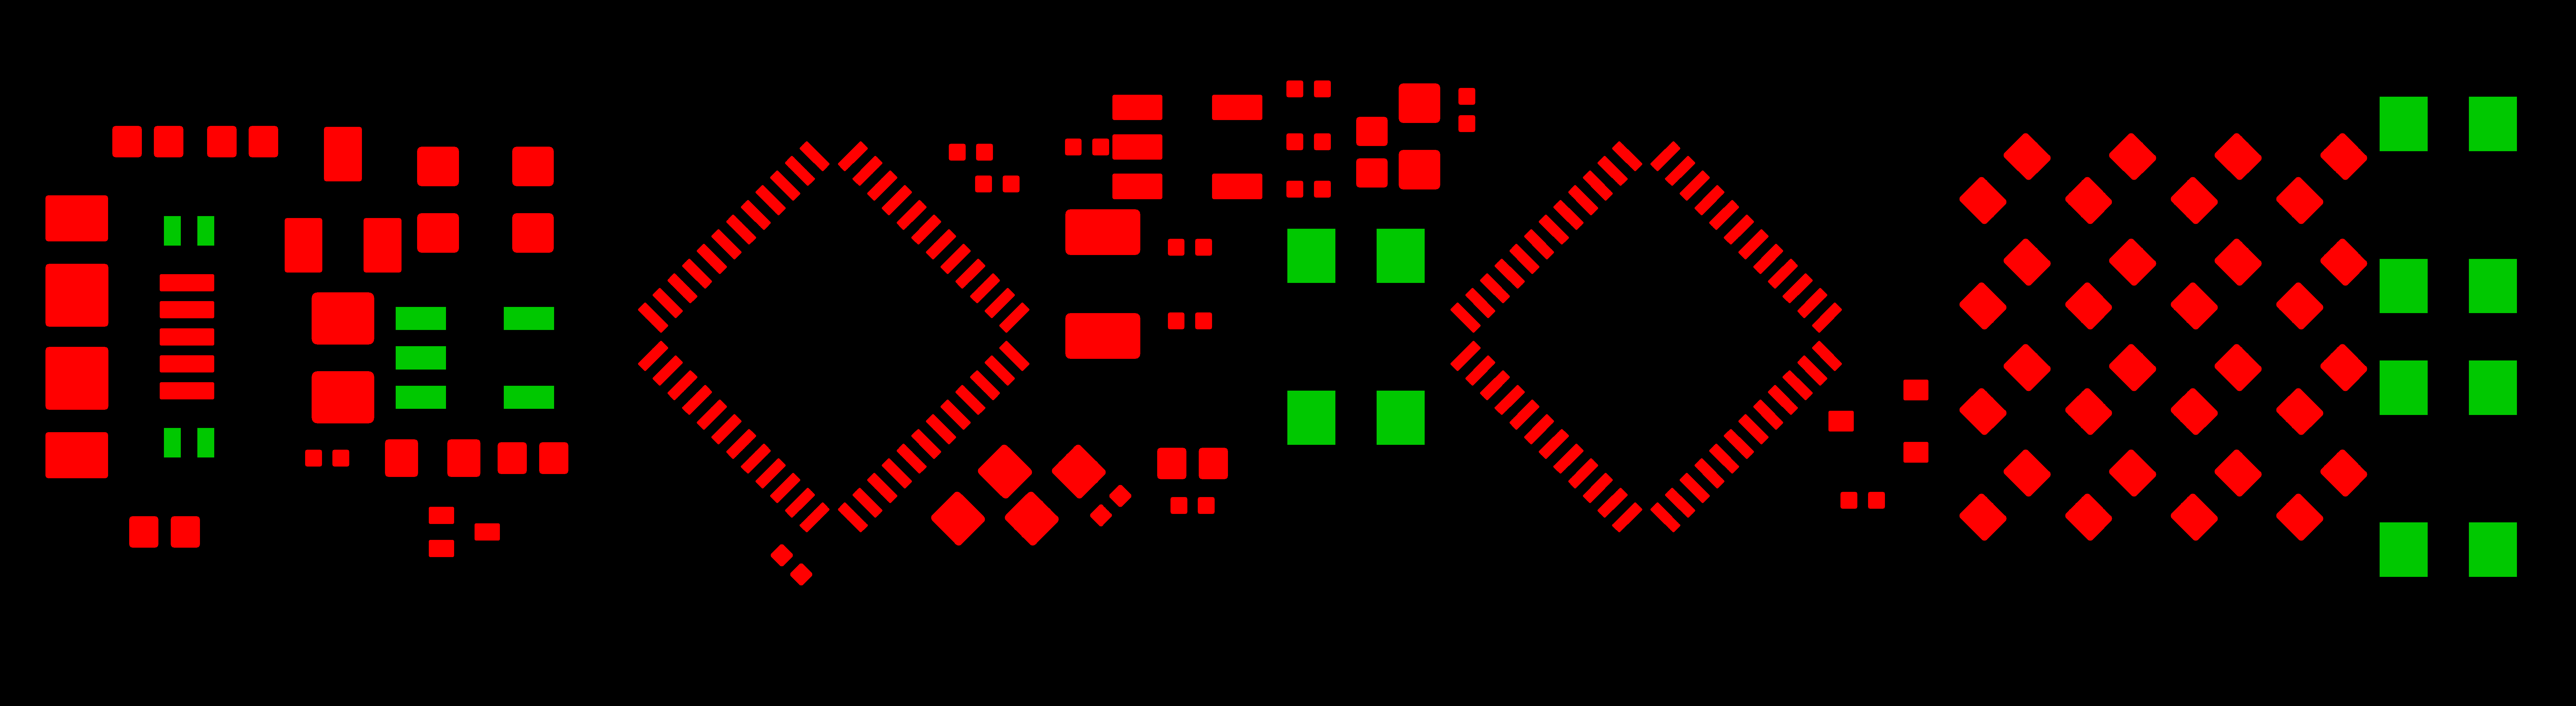

In [3]:
# Helper Function to Draw cv2 images in jupyter
def showarray(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
# create a new Image using 128px per mm
height = int(bound_y) * 128 + 256
width  = int(bound_x) * 128 + 256
blank_image = np.zeros((height,width,3), np.uint8)
# draw pads from gerber file
for i in stencil.primitives:
    if isinstance(i,gerber.primitives.Line ): # some elements are simple lines,need also thickness to correct fill 
        p1 = (int(i._start[0] * 128) , int(i._start[1] * 128))
        p2 = (int(i._end[0]   * 128) , int(i._end[1]   * 128) )
        cv2.line(   img=blank_image, pt1=p1,pt2=p2, 
                    color=(255,0,0) , thickness = int(i.aperture._diameter*128) , lineType = 8, shift = 0)
    elif isinstance(i,gerber.primitives.Rectangle ): # draw rectanges
        x1 = int((i._position[0] - i._width * 0.5)  * 128)
        y1 = int((i._position[1] - i._height* 0.5)  * 128)
        x2 = int((i._position[0] + i._width * 0.5)  * 128)
        y2 = int((i._position[1] + i._height* 0.5)  * 128)
        cv2.rectangle(blank_image, (x1,y1), (x2,y2), color=(0,200,0), thickness = -1)
flip_img = cv2.flip(blank_image, -1)
flip_img = cv2.flip(flip_img, 1)
showarray(flip_img)

mm drive len: 328269.2726856326
mm drive len: 222114.69606512008
mm drive len: 190520.03304184365
New mm drive len: 176744.22535986925


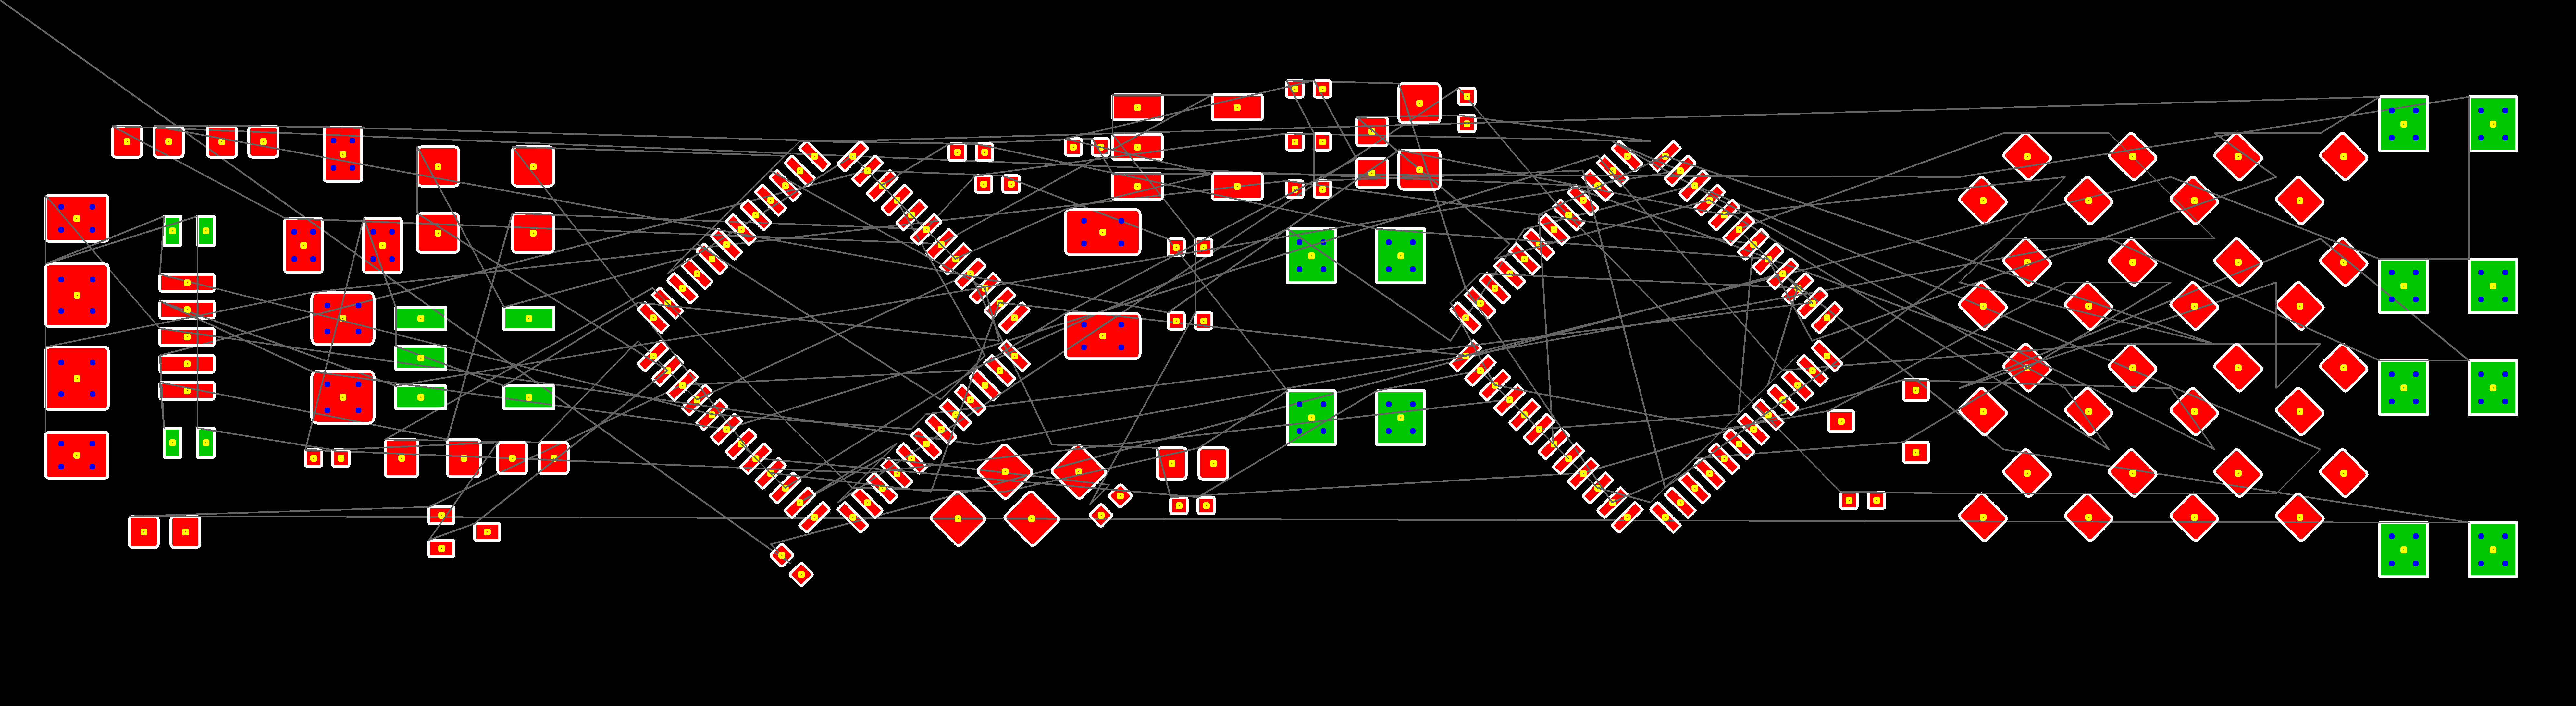

Pad Counter: 320


In [5]:
# found contours to find solder paste points
counter  = 0
imgOrg   = flip_img.copy()  
imgGray  = cv2.cvtColor(flip_img,cv2.COLOR_BGR2GRAY)
contours, hierarchy  = cv2.findContours(imgGray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
csv=""
x_old=0
y_old=0 # for route 


## START optimize route by simple TSP heuristic
def distance_contour(c1, c2):
    x1, y1, w1, h1 = cv2.boundingRect(c1)
    x2, y2, w2, h2 = cv2.boundingRect(c2)
    return ((x1 - x2)**2 + (y1 - y2)**2) ** 0.5
def tsp_len(seq): # compute distance
    l=0
    fr=seq[0]
    for i, contour in enumerate(seq):
        l=l+distance_contour(fr,contour)
        fr=contour
    return l

def swap_random(seq):
    idx = range(len(seq))
    i1, i2 = random.sample(idx, 2)
    seq[i1], seq[i2] = seq[i2], seq[i1]

l=tsp_len(contours)
for i in range(0, 30000): # <--- tune high values -> cpu load
    ccopy = contours.copy()
    for ii in range(1, random.randint(1,7)):
        swap_random(ccopy)
    lnew=tsp_len(ccopy)
    if lnew < l :
        l = lnew
        contours = ccopy
    if (i % 10000) == 0:
        print("mm drive len:", l)
print("New mm drive len:", l)
## END optimize route by simple TSP heuristic





for i, contour in enumerate(contours):
    #print(i);
    x, y, w, h = cv2.boundingRect(contour)
    if(x==0 & y==0): continue
    center1 = (x+w//2 -6, y+h//2 -6)
    center2 = (x+w//2 +6, y+h//2 +6)
    csv=csv + "\n" + str(x/128.0) + " ,  " + str(y/128.0)
    cv2.drawContours(imgOrg, contour, -1, (255, 255, 255), 8) # draw outline bounds

    cv2.line(   img=imgOrg, pt1=(x,y),pt2=(x_old,y_old), 
                    color=(100,100,100) , thickness = 4 , lineType = 8, shift = 0) # show trace, so looks like we need optimize driver too
    
    
    cv2.rectangle(imgOrg, center1, center2, (255, 255, 0), 8) # draw bounds
    counter=counter+1
    #if w > 160 or h > 160: # draw some extra dots on bigger pads, need 
    if cv2.contourArea(contour) > 18800: # or check by area size <---NEED to TUNE
        for xd in np.arange (x + w//4  , x + w , w//2):
            for yd in np.arange (y + h//4  , y + h , h//2):
                center1 = (xd - 4, yd - 4)
                center2 = (xd + 4, yd + 4)
                if cv2.pointPolygonTest(contour,(xd,yd),False)==1 :
                    cv2.rectangle(imgOrg, center1, center2, (0, 0, 255), 8) # draw bounds, TODO: add some patterns for bigger pads
                    csv=csv + "\n" + str(xd/128.0) + " ,  " + str(yd/128.0)
                    counter=counter+1
    
    x_old = x
    y_old = y
    
    
showarray(imgOrg)
print("Pad Counter:", counter)

In [6]:
print(csv)


19.015625 ,  13.5625
18.546875 ,  13.1015625
42.8984375 ,  6.578125
48.21875 ,  10.8203125
59.421875 ,  12.578125
59.7109375 ,  12.90625
59.7109375 ,  13.5625
60.2890625 ,  12.90625
60.2890625 ,  13.5625
57.2734375 ,  12.578125
57.5625 ,  12.90625
57.5625 ,  13.5625
58.140625 ,  12.90625
58.140625 ,  13.5625
4.109375 ,  12.4296875
3.109375 ,  12.4296875
10.3203125 ,  12.203125
16.4140625 ,  9.265625
23.34375 ,  8.9140625
30.984375 ,  5.5078125
31.2734375 ,  5.828125
31.2734375 ,  6.4765625
31.8515625 ,  5.828125
31.8515625 ,  6.4765625
34.90625 ,  8.203125
36.6796875 ,  5.515625
40.78125 ,  4.453125
55.84375 ,  10.8203125
54.78125 ,  11.8828125
52.2421875 ,  11.8828125
49.703125 ,  11.8828125
47.15625 ,  11.8828125
44.9609375 ,  11.84375
44.296875 ,  11.84375
37.3828125 ,  4.8125
35.1015625 ,  2.1171875
20.1640625 ,  12.09375
21.578125 ,  10.6796875
19.2421875 ,  12.09375
21.21875 ,  11.03125
26.6953125 ,  11.671875
26.234375 ,  12.140625
28.765625 ,  7.5234375
28.765625 ,  5.75
26.77